In [92]:
# new syntax playground

#I think arange creates an array
#np.arange(3) ** 2 # array range.
# result: array([0, 1, 4])

# creating a list using list comprehension:
#varList = [e**2 for e in range(3,7)]
#print (varList) # result: [9, 16, 25, 36]
# whereas range, just generates a series of numbers not really an array.
#for x in range(0,3): print( x **2) # 0, 1, 4

#timeit is awesome!   It takes a while to gather stats and has funny syntax with %, but it is great for performance
# checking.  Seems to be part of sys.
#%timeit np.arange(3) ** 2

In [93]:
import os
import numpy as np
import sys

imdb_dir = '/home/sbradley/tensorflow/mlenv/chollet_book/movieReviews/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

# pulls in all 12,500 items in neg and pos dirs for total of 25,000 items!
for label_type in ['neg', 'pos']:
    dir_names = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_names):
        if fname[-4:] =='.txt':  # cool to use slicing on a string!
            f = open(os.path.join(dir_names, fname))
            texts.append(f.read())
            if label_type =='neg':
                labels.append(0)
            else:
                labels.append(1)

In [94]:
# Tokenize the data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 200 # originally 100 in Chollet
training_samples = 10000  # originally 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # % subs for comma if embedding in text!

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of labels tensor: ', labels.shape)
'''
Found 88582 unique tokens.
Shape of data tensor:  (25000, 100)
Shape of labels tensor:  (25000,)
'''
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]  # indices is a shuffled numpy array of indices
labels = labels[indices]

# take only 200 training samples
x_train = data[:training_samples]
y_train = labels[:training_samples]

# take 10,000 training samples
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]
    

Found 88582 unique tokens.
Shape of data tensor:  (25000, 200)
Shape of labels tensor:  (25000,)


In [95]:
glove_dir = '/home/sbradley/tensorflow/mlenv/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close

print(' Found %s word vectors.' % len(embeddings_index))
#Found 400000 word vectors.

 Found 400000 word vectors.


In [96]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # talking about conversant syntax!
            embedding_matrix[i] = embedding_vector
#print('Expect shape of embedding_matrix to be max_words = ', max_words) 
# Python 3 approach to formatted strings:
print('actual max_words = {}, embedding_dim = {}, '.format(max_words, embedding_dim))
print('actual shape = ', embedding_matrix.shape)   
#print(embedding_matrix[0:3])
'''
[[ 0.          0.          0.          0.          0.          0.
   ***all zeros for first sequence--placeholde only***        0.
   0.          0.          0.          0.        ]
 [-0.038194   -0.24487001...0.27061999]   # Essentially no zeros in embeddings
 [-0.071953 ...-0.71894997  0.86894     0.19539   ]]
 '''

actual max_words = 10000, embedding_dim = 100, 
actual shape =  (10000, 100)


'\n[[ 0.          0.          0.          0.          0.          0.\n   ***all zeros for first sequence--placeholde only***        0.\n   0.          0.          0.          0.        ]\n [-0.038194   -0.24487001...0.27061999]   # Essentially no zeros in embeddings\n [-0.071953 ...-0.71894997  0.86894     0.19539   ]]\n '

In [97]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words,embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,640,065
Trainable params: 1,640,065
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pretrained_glove_model.h5')

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 6s 560us/step - loss: 0.8282 - acc: 0.5982 - val_loss: 0.6631 - val_acc: 0.6127
Epoch 2/10
10000/10000 [==============================] - 6s 565us/step - loss: 0.5276 - acc: 0.7341 - val_loss: 0.5658 - val_acc: 0.7092
Epoch 3/10
10000/10000 [==============================] - 6s 646us/step - loss: 0.4196 - acc: 0.8062 - val_loss: 0.5860 - val_acc: 0.7091
Epoch 4/10
10000/10000 [==============================] - 6s 596us/step - loss: 0.3274 - acc: 0.8600 - val_loss: 0.6293 - val_acc: 0.7036
Epoch 5/10
10000/10000 [==============================] - 6s 621us/step - loss: 0.2613 - acc: 0.8954 - val_loss: 0.6964 - val_acc: 0.6988
Epoch 6/10
10000/10000 [==============================] - 5s 538us/step - loss: 0.1950 - acc: 0.9242 - val_loss: 0.7591 - val_acc: 0.7013
Epoch 7/10
10000/10000 [==============================] - 6s 579us/step - loss: 0.1401 - acc: 0.9491 - val_loss: 1.1711 - 

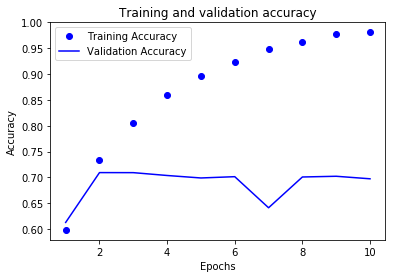

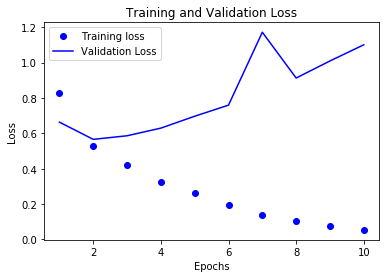

" So it looks like val_acc: 0.5699 or 57% with only 200 samples.  \nThis is not good compared to \n Train on 200 samples, validate on 10000 samples.\n \n In Chollet, tried without pre-trained embeddings and this didn't work \n as well--low 50% area.\n \n With 10,000 samples instead of 200, still super quick--got 67%--much better!\n \n "

In [99]:
import matplotlib.pyplot as plt

acc = history.history['acc']
validation_acc = history.history['val_acc']
loss = history.history['loss']
validation_loss = history.history['val_loss']
#print("validation_loss: ", validation_loss) 

epochs = range(1,len(acc) + 1) # list

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

''' So it looks like val_acc: 0.5699 or 57% with only 200 samples.  
This is not good compared to 
 Train on 200 samples, validate on 10000 samples.
 
 In Chollet, tried without pre-trained embeddings and this didn't work 
 as well--low 50% area.
 
 With 10,000 samples instead of 200, still super quick--got 67%--much better!
 
 upped max_len to 200 from 100, this helped--up now to 72% and only about 2 minutes!
 '''

In [100]:
# Try without the word embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words,embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# skip these this time:
#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                640032    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,640,065
Trainable params: 1,640,065
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))


Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 12s 1ms/step - loss: 0.4986 - acc: 0.7418 - val_loss: 0.4205 - val_acc: 0.8067
Epoch 2/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1095 - acc: 0.9621 - val_loss: 0.4102 - val_acc: 0.8363
Epoch 3/10
10000/10000 [==============================] - 10s 1ms/step - loss: 0.0105 - acc: 0.9975 - val_loss: 0.5389 - val_acc: 0.8365
Epoch 4/10
10000/10000 [==============================] - 10s 1ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.6913 - val_acc: 0.8335
Epoch 5/10
10000/10000 [==============================] - 12s 1ms/step - loss: 2.0639e-05 - acc: 1.0000 - val_loss: 0.8344 - val_acc: 0.8283
Epoch 6/10
10000/10000 [==============================] - 11s 1ms/step - loss: 3.9906e-07 - acc: 1.0000 - val_loss: 0.9438 - val_acc: 0.8278
Epoch 7/10
10000/10000 [==============================] - 12s 1ms/step - loss: 1.1896e-07 - acc: 1.0000 - val_loss: 0.98

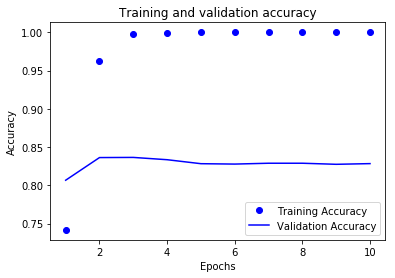

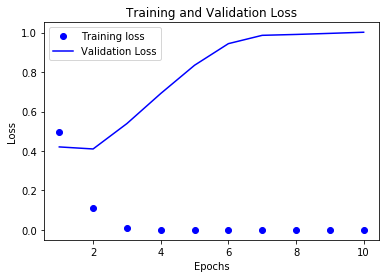

'\nval_acc: 0.5283 is lower than with pre-trained--still very fast due to\nthe small training set of 200.\n\nWith 10,000 samples instead of 200, still super quick--got 82%. \nmuch better!  Why is it better than the Glove embedded? I guess\nusing specialized training is overall better--and this time it was still fast...\n \n'

In [102]:

acc = history.history['acc']
validation_acc = history.history['val_acc']
loss = history.history['loss']
validation_loss = history.history['val_loss']
#print("validation_loss: ", validation_loss) 

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

'''
val_acc: 0.5283 is lower than with pre-trained--still very fast due to
the small training set of 200.

With 10,000 samples instead of 200, still super quick--got 82%. 
much better!  Now it is better than the Glove embedded? I guess
using specialized training is overall better.
And this time it was still fast...
 
 upped max_len of vecs to 200 from 100, this helped even more
 up now to 82% and only about 2 minutes!
'''